In [1]:
import json
import pandas as pd
import tensorflow as tf

labelPath = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/label_num_to_disease_map.json"

with open(labelPath, "r") as f:
    label_map = json.load(f)

print(label_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [2]:
# Load images and their labels 
trainLabel = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/train.csv"

df = pd.read_csv(trainLabel)
print(df.head())

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


In [3]:
# Build full image paths 
imagePathBase = "C:/Users/RA_CT/Desktop/Tek_Juice/cldModel/cassava-leaf-disease-classification/train_images"

image_paths = [imagePathBase + "/" + img for img in df["image_id"]]
labels = df["label"].values   # numeric labels

In [4]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.1,
    stratify=labels,
    random_state=42
)

print(len(train_paths), "train images")
print(len(val_paths), "validation images")

19257 train images
2140 validation images


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMAGE_SIZE = 224
BATCH_SIZE = 32

def process_image(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    if training:
        img = data_augmentation(img)
    img = preprocess_input(img)
    return img, label


In [7]:
# Build TF datasets (train + validation) 
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [8]:
# Verify sample image 
for img, lbl in train_ds.take(1):
    print(img.shape, lbl.shape)
    break


(32, 224, 224, 3) (32,)


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False   

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(
    256,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = Dense(
    128,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

output = Dense(5, activation='softmax')(x)


In [10]:
model = Model(inputs=base_model.input, outputs=output)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2,
        min_lr=1e-6
    )
]

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 449s 724ms/step - accuracy: 0.6317 - loss: 1.1485 - val_accuracy: 0.7079 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 2/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 431s 709ms/step - accuracy: 0.7050 - loss: 0.8689 - val_accuracy: 0.7379 - val_loss: 0.7746 - learning_rate: 0.0010
Epoch 3/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 439s 724ms/step - accuracy: 0.7215 - loss: 0.8132 - val_accuracy: 0.7304 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 4/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 446s 733ms/step - accuracy: 0.7373 - loss: 0.7880 - val_accuracy: 0.7364 - val_loss: 0.7711 - learning_rate: 0.0010
Epoch 5/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 434s 713ms/step - accuracy: 0.7375 - loss: 0.7753 - val_accuracy: 0.7463 - val_loss: 0.7588 - learning_rate: 0.0010
Epoch 6/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 394s 648ms/step - accuracy: 0.7385 - loss: 0.7670 - val_accuracy: 0.7407 - val_loss: 0.7700 - learning_rate: 0.0010
Epoch 7/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 403s 662ms/step - accura

In [14]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [15]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

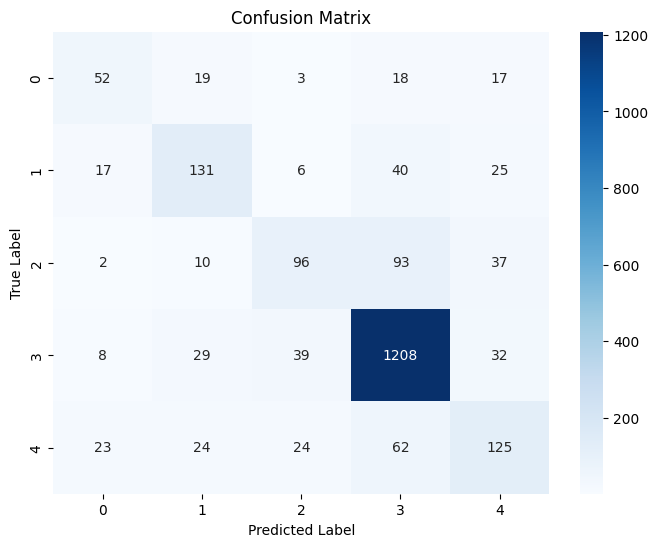

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [17]:
# classification report 
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.48      0.49       109
           1       0.62      0.60      0.61       219
           2       0.57      0.40      0.47       238
           3       0.85      0.92      0.88      1316
           4       0.53      0.48      0.51       258

    accuracy                           0.75      2140
   macro avg       0.62      0.58      0.59      2140
weighted avg       0.74      0.75      0.74      2140



In [18]:
class_names = [label_map[str(i)] for i in range(5)]
print(classification_report(y_true, y_pred, target_names=class_names))


                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.51      0.48      0.49       109
Cassava Brown Streak Disease (CBSD)       0.62      0.60      0.61       219
         Cassava Green Mottle (CGM)       0.57      0.40      0.47       238
       Cassava Mosaic Disease (CMD)       0.85      0.92      0.88      1316
                            Healthy       0.53      0.48      0.51       258

                           accuracy                           0.75      2140
                          macro avg       0.62      0.58      0.59      2140
                       weighted avg       0.74      0.75      0.74      2140



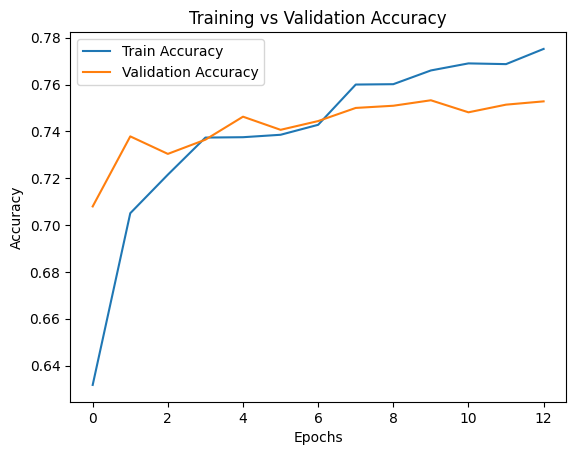

In [19]:
# Accrancy and loss curve 
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


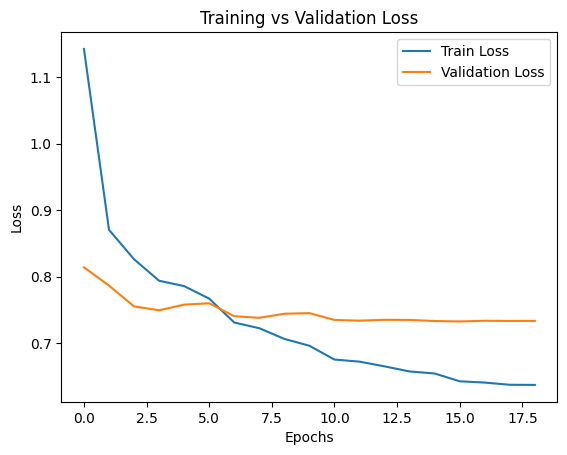

In [23]:
# Plot loss 
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [21]:
model.save("cassava_model_v3.keras")

In [22]:
model.save("cassava_model_v3.h5")

In [23]:
model.export("cassava_model_v3")

INFO:tensorflow:Assets written to: cassava_model_v3\assets


INFO:tensorflow:Assets written to: cassava_model_v3\assets


Saved artifact at 'cassava_model_v3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1667160941216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160943680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160948432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160934352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160940336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160936112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160999888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160998304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160998832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667161002528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1667160997952: TensorSpec(shape=()